In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import pickle
import ast
import xarray as xr

In [2]:
#load and unpack data
with open("Data_A\\ReadyData_Synth_A.pkl", "rb") as f:
    data_dict = pickle.load(f)

cov_mat = data_dict['cov_mat']
grp_idx = data_dict['grp_idx']
obs_data = data_dict['resp']
params_fixed = data_dict['params_fixed']

In [3]:
exec(open("Build_Model_A.py").read())

model is built!


Prior Predictive Checks

Sampling: [resp, z_beta, z_gam_h, z_gam_l]


Text(0.5, 1.0, 'Prior predictive checks – group left_bi')

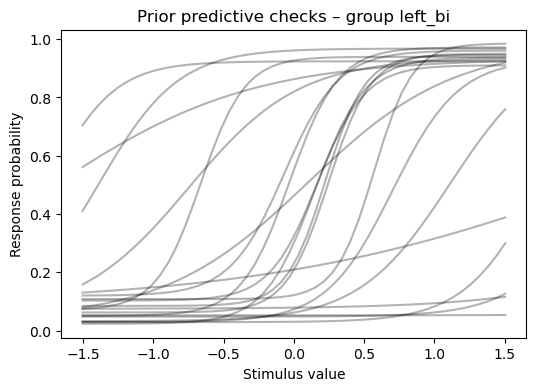

In [8]:
# PRIOR PREDICTIVE CHECKS
# Draw prior predictive samples
with model_A:
    idata_prior = pm.sample_prior_predictive(20)

prior = idata_prior.prior
prior_pred = idata_prior.prior_predictive

# Pick a group to visualize (e.g. "left_bi")
group_name = "left_bi"
group_idx = model_A.coords["groups"].index(group_name)

# Build a predictor grid
stim_grid = np.linspace(cov_mat[:,1].min(), cov_mat[:,1].max(), 50)  # the stimulus values
X_grid = np.column_stack([np.ones_like(stim_grid), stim_grid])

# Convert to xarray for nice broadcasting
stim_xr = xr.DataArray(stim_grid, dims=["plot_dim"])

# Extract priors for this group
beta = prior["beta_vec"].sel(betas="b1", groups=group_name)  # slope
intercept = prior["beta_vec"].sel(betas="b0", groups=group_name)
gam_h = prior["gam_h"].sel(groups=group_name)
gam_l = prior["gam_l"].sel(groups=group_name)

# Compute linear predictor for each draw
linpred = intercept + beta * stim_xr

# Pass through logistic link with lapse rates
p = gam_h + (1 - gam_h - gam_l) * 1/(1+np.exp(-linpred))

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(stim_grid, p.stack(sample=("chain","draw")), c="k", alpha=0.3)

ax.set_xlabel("Stimulus value")
ax.set_ylabel("Response probability")
ax.set_title(f"Prior predictive checks – group {group_name}")